In [1]:
#Reference: 
#   Cunxi Yu, Houping Xiao and Giovanni De Micheli. 
#   "Developing Synthesis Flows without Human Knowledge." ACM/IEEE Design Automation Conference (DAC'18)
#   Contact: Cunxi Yu.  Email: cunxi.yu@epfl.ch
#
#
#Demo: Input design/datasets: 64-bit GF-Mont with delay labels.
#        Number of classes: 7 (0-6)
#Demo 
#    Training Results:
#        1) Angel flows classifcation (class-0): 93%
#        2) Devil flows classifcation (class-0): 89%
#        3) overall accuracy of classifer 74.2%         
#
#    Testing Results (20,000 * 3 test points): 
#        1) Angel flows classifcation (class-0): 93%,92%,93%
#        2) Devil flows classifcation (class-0): 90%,90%,90%
#        3) overall accuracy of classifer 73.6%, 73.4%, 73.6%
#

In [2]:
# ***********WE DEMO INFERENCE IN THIS FILE ONLY ***********
# *********  TRAINING PLS SEE THE OTHER NOTEBOOK FILE ******
#     Input pre-trained model: dac18_GF_delay_model_save_test.h5

In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D,Flatten,MaxPooling2D
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
from sklearn.metrics import confusion_matrix
import itertools




ModuleNotFoundError: No module named 'keras'

In [4]:
def read_csv_data(csv_filename, header=None, num_funcs=6, shuffle_data=True):
    """helper function to read data from csv file
    return X and Y
    X.shape = (num_samples, length_seq, num_funcs)
    Y.shape = (num_samples, num_classes)
    """
    # read data
    data = pd.read_csv(csv_filename, header=header)
    data = data.as_matrix()
    if (shuffle_data):
        data = shuffle(data)

    # extract X and Y
    X = data[:, :-1]#.reshape((-1, int((data.shape[1]-1)/num_funcs), num_funcs))
    X = data[:, :-1].reshape(X.shape[0], 1, 24, 6)
    Y = data[:, -1]

    # convert Y to one-hot vectors
    Y = to_categorical(Y, num_classes=Y.max()+1)

    return X, Y

In [5]:
from keras.callbacks import Callback
from IPython.display import clear_output
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1

        #self.plot_history()

    def plot_history(self):
        #f, ax1 = plt.subplots()
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        clear_output(wait=True)
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        plt.show()

plot_learning = PlotLearning()

In [6]:
## *******   LOADING PRE-TRAINED MODEL HERE *******
import h5py
from keras.models import load_model
model = load_model('dac18_GF_delay_model_save_test.h5')

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          print_raw_cm=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_raw_cm):
            print("Normalized confusion matrix")
    else:
        if (print_raw_cm):
            print('Confusion matrix, without normalization')

    if (print_raw_cm):
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greys)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def evaluate(model, X_test, Y_test, classes,NAME):
    """evaluate dataset and plot confusion matrix"""
    # predict from X_test
    Y_pred = model.predict(X_test)
    Y_pred_label = np.argmax(Y_pred, axis=-1)
    Y_test_label = np.argmax(Y_test, axis=-1)


    print("Prediction accuracy = %f" %(float(sum(Y_pred_label == Y_test_label))/Y_test_label.shape[0]))
    cnf_matrix = confusion_matrix(Y_test_label, Y_pred_label)


    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                          title='Normalized confusion matrix\n Angel-class:class-0\n Devil-class:class-6')
    
    plt.show()



((20000, 1, 24, 6), (20000, 7))
Prediction accuracy = 0.736200


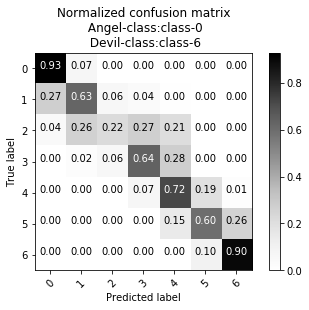

In [8]:
## testing (inference)
# 1st testing input datasets: 20000 untested flows, test2.csv

folder_path = 'datasets/64bitGF/delay/'
csv_filename = 'test2.csv'
X, Y = read_csv_data(folder_path + csv_filename, header=None, num_funcs=6)
print(X.shape, Y.shape)
evaluate(model, X, Y, classes=range(0,Y.shape[1]),NAME = "origin_delay_")

Prediction accuracy = 0.733800


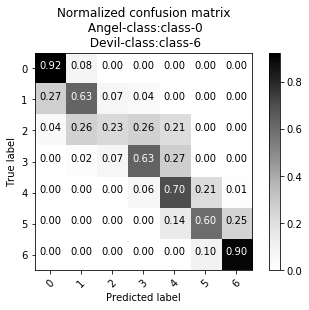

In [9]:
## testing (inference)
# 2nd testing input datasets: 20000 untested flows, test3.csv

folder_path = 'datasets/64bitGF/delay/'
csv_filename = 'test3.csv'
X, Y = read_csv_data(folder_path + csv_filename, header=None, num_funcs=6)
#print(X.shape, Y.shape)
evaluate(model, X, Y, classes=range(0,Y.shape[1]),NAME = "origin_delay_")

Prediction accuracy = 0.736150


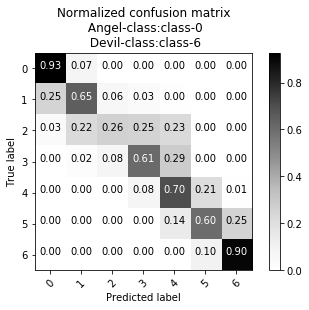

In [10]:
## testing (inference)
# 3rd testing input datasets: 20000 untested flows, test4.csv

folder_path = 'datasets/64bitGF/delay/'
csv_filename = 'test4.csv'
X, Y = read_csv_data(folder_path + csv_filename, header=None, num_funcs=6)
#print(X.shape, Y.shape)
evaluate(model, X, Y, classes=range(0,Y.shape[1]),NAME = "origin_delay_")